In [9]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [10]:
import numpy as np

from matplotlib import pyplot as plt

import json

from tqdm import tqdm

import utils

from modules import helpers, fitting

import importlib
importlib.reload(utils)
importlib.reload(helpers)
importlib.reload(fitting)

helpers.set_plot_configs()

In [11]:
calibration = utils.MCACalibration('data/2025-03-04/Calibration_recoil_na_0304.Spe',
                                   'data/2025-03-04/Calibration_recoil_ba_0304.Spe',
                                   kernel_bw=5,cs_137_approx_line_bin=1800,)

In [12]:
DataReader = utils.MCAData()

def show_calibration_spectrum(ax,sub_ax,isotope='na',file_base=['data/2025-03-04/Calibration_recoil_','_0304.Spe'],
                              kernel_bw=5,cs_137_approx_line_bin=1800,
                              ylim=[0,8000],xlabel=None):
    # Process data
    bins, counts, _, _ = DataReader._read_data(file_base[0]+isotope+file_base[1])
    normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
    kde_bins, kdes, kdes_err = DataReader._kde_smooth_data(bins, counts, bw=kernel_bw)
    peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kdes, kdes_err)

    calibration = utils.MCACalibration(file_base[0]+'na'+file_base[1],file_base[0]+'ba'+file_base[1],
                                       kernel_bw=kernel_bw,cs_137_approx_line_bin=cs_137_approx_line_bin,)

    # Plot spectrum
    ax.plot(bins, counts, color='darkcyan', label='Spectrum' if isotope == 'na' else None)
    ax.plot(kde_bins, kdes*normalizing_factor, color='darkblue', ls='--', label='KDE' if isotope == 'na' else None)

    # for peak_idx in peaks_idx:
    #     ax.axvline(kde_bins[peak_idx], color='darkblue', ls='--', dashes=(1.5,2), lw=2)
    # for valley_idx in valleys_idx:
    #     ax.axvline(kde_bins[valley_idx], color='chocolate', ls='--', dashes=(1.5,2), lw=2)

    if isotope == 'na':
        peaks_mu = list(calibration.na_22_peak_mu)
        peaks_fitting_bins = [calibration.na_22_fitting_bins]
        peaks_fitted_counts = [calibration.na_22_fitted_counts]
    if isotope == 'ba':
        peaks_mu = []
        for mus in calibration.ba_133_peaks_mu:
            peaks_mu += list(mus)
        peaks_mu += list(calibration.cs_137_peak_mu)
        peaks_fitting_bins = calibration.ba_133_fitting_bins + [calibration.cs_137_fitting_bins]
        peaks_fitted_counts = calibration.ba_133_fitted_counts + [calibration.cs_137_fitted_counts]

    for i, (fitting_bins, fitted_counts) in enumerate(zip(peaks_fitting_bins, peaks_fitted_counts)):
        ax.plot(fitting_bins,fitted_counts, color='maroon', ls='-', lw=3, label='Peak Fits' if isotope == 'na' and not i else None)
        # ax.axvline(fitting_bins[0], color='maroon', ls='--', lw=2)
        # ax.axvline(fitting_bins[-1], color='maroon', ls='--', lw=2)

    for mu in peaks_mu:
        ax.axvline(mu, color='maroon', ls='--', lw=2)

    ax.set_xlim(0,2047)
    ax.set_ylim(ylim)

    if isotope == 'ba':
        ax.set_xlabel('Channel')
    ax.set_ylabel(xlabel)

    ax.legend(loc='upper left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
    
    # Plot energy calibration
    if isotope == 'ba':
        sub_ax.patch.set_alpha(0.9)

        sub_ax.scatter(calibration.calib_bins, calibration.calib_energies, marker='+', s=100, color='maroon', zorder=-1)

        bins_dense = np.linspace(0, 1800, 1000)
        sub_ax.plot(bins_dense, calibration.energy_scaler*bins_dense + calibration.energy_offset, color='black', ls='--',zorder=-2,label='Energy Calibration')

        for i in range(300):
            scaler = np.random.normal(calibration.energy_scaler,calibration.energy_scaler_err)
            offset = np.random.normal(calibration.energy_offset,calibration.energy_offset_err)

            sub_ax.plot(bins_dense, scaler*bins_dense + offset, color='grey', alpha=0.01, zorder=-3)

        sub_ax.set_xlabel('Channel', fontsize=20)
        sub_ax.set_ylabel('Energy [keV]', fontsize=20)

        sub_ax.tick_params(axis='both', labelsize=20)

        sub_ax.set_xlim(0, 1800)
        sub_ax.set_ylim(0, 700)

        sub_ax.set_xticks([0,500,1000,1500])
        sub_ax.set_yticks([0,200,400,600])

        sub_ax.legend(loc='upper left', frameon=False, fontsize=20, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

        # sub_ax.yaxis.tick_right()
        # sub_ax.yaxis.set_label_position("right")

/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_33721/3746996181.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_33721/289676947.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


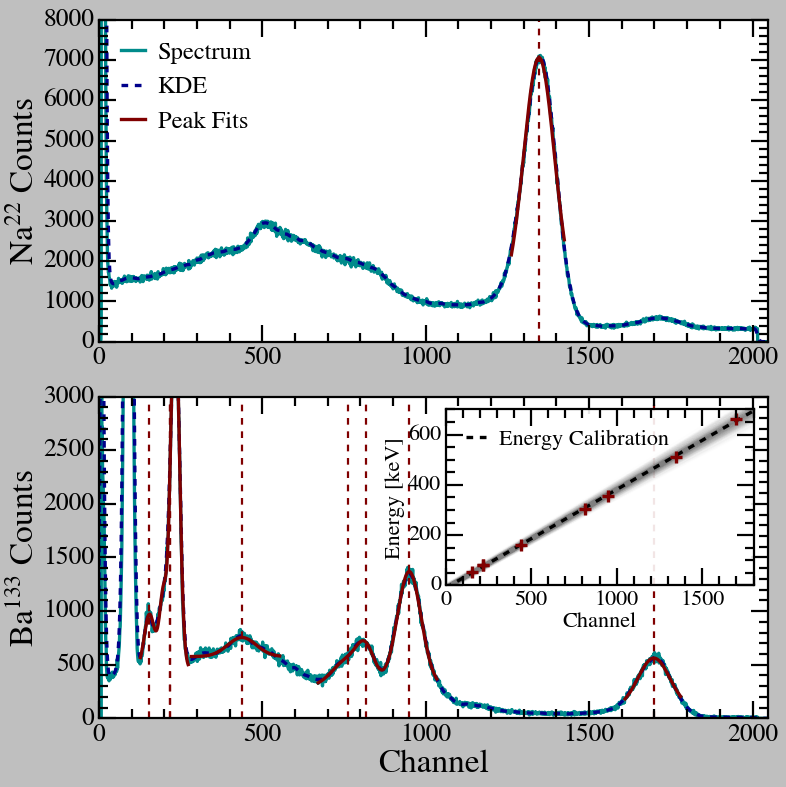

In [13]:
ylims = {
    'na': [0,8000],
    'ba': [0,3000],
}

xlabels = {
    'na': r'Na$^{22}$ Counts',
    'ba': r'Ba$^{133}$ Counts',
}

fig, axs = plt.subplots(2,1,figsize=(10, 10))

# fig.add_subplot((0.15,0.75,0.35,0.2))
# fig.add_subplot((0.60,0.28,0.35,0.2))

sub_ax = fig.add_subplot((0.565,0.26,0.385,0.22))

for i, isotope in enumerate(['na','ba']):
    show_calibration_spectrum(axs[i],sub_ax=sub_ax,
                              isotope=isotope,
                              ylim=ylims[isotope],
                              xlabel=xlabels[isotope])

plt.tight_layout()
plt.savefig('report/Figures/energy_calibration.png')

plt.show()

In [14]:
if False:
    DataReader = utils.MCAData()

    bins, counts, _, _ = DataReader._read_data('data/2025-03-04/scatter_30_0304.Spe')
    count_normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
    kde_bins, kdes, kdes_err = DataReader._kde_smooth_data(bins, counts, bw=5)
    peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kdes, kdes_err)

    approx_peak_idx = peaks_idx[
        np.argmin(np.abs(bins[peaks_idx] - 1400))
    ]
    approx_peak_bin = bins[approx_peak_idx]
    approx_peak_kde = kdes[approx_peak_idx]

    lower_idx, upper_idx = DataReader._get_fitting_boundaries(bins,kdes,peaks_idx,valleys_idx,
                                                            approx_peak_bin,approx_peak_bin,
                                                            threshold=approx_peak_kde/3,threshold_ratio=1,
                                                            outward=False)

    compton = utils.MCACompton(data_base='30_0304.Spe',data_dir='data/2025-03-04/',)

    peak_mu_count, peak_mu_count_err, peak_sigma_count, peak_sigma_count_err, \
    peak_mu_energy, peak_mu_energy_err, peak_sigma_energy, peak_sigma_count_err, \
    peak_fwhm_rate, peak_fwhm_rate_err, fitting_bins, fitted_counts, peak_mu_bin_deviation = compton._peak_analysis('scatter')
    print(peak_mu_count, peak_mu_count_err, peak_sigma_count, peak_sigma_count_err)

In [15]:
if False:
    fig, ax = plt.subplots(figsize=(10, 7))

    ax.plot(bins, counts)
    ax.plot(kde_bins, kdes*count_normalizing_factor)
    # ax.errorbar(kde_bins, kde, yerr=kde_err,
    #             fmt=' s',markersize=1,elinewidth=2,capsize=5)

    for peak_idx in peaks_idx:
        ax.axvline(kde_bins[peak_idx], color='r', linestyle='--')
    for valley_idx in valleys_idx:
        ax.axvline(kde_bins[valley_idx], color='g', linestyle='--')

    # ax.axvline(kde_bins[lower_idx], color='b', linestyle='--')
    # ax.axvline(kde_bins[upper_idx], color='b', linestyle='--')

    ax.plot(fitting_bins, fitted_counts, color='r')

    # for fitting_bins, gaussian_counts in zip(calibration.ba_133_fitting_bins+[calibration.cs_137_fitting_bins],
    #                                          calibration.ba_133_fitted_counts+[calibration.cs_137_fitted_counts]):
    #     if fitting_bins is not None:
    #         ax.plot(fitting_bins, gaussian_counts/count_normalizing_factor, color='r')

    ax.set_xscale('linear')
    # ax.set_yscale('log')

    ax.set_xlim(0, 2048)
    ax.set_ylim(0, 50)

    plt.tight_layout()
    plt.show()

In [16]:
metadata = {
    0 : ['0_0304.Spe','data/2025-03-04'],
    30 : ['30_0304.Spe','data/2025-03-04'],
    60 : ['60_0304.Spe','data/2025-03-04'],
    90 : ['90_0304.Spe','data/2025-03-04'],
    120 : ['120_0304.Spe','data/2025-03-04'],

    15 : ['15_0306.Spe','data/2025-03-06'],
    45 : ['45_0306.Spe','data/2025-03-06'],
    75 : ['75_0306.Spe','data/2025-03-06'],
    105 : ['105_0306.Spe','data/2025-03-06'],
    135 : ['135_0306.Spe','data/2025-03-06'],
}

In [17]:
for angle in metadata:
    data_file = os.path.join(metadata[angle][1],'scatter_'+metadata[angle][0])
    
    bins, counts, counting_time, total_time = DataReader._read_data(data_file)

    print(f'{angle:.0f} & {counting_time:.0f} & {total_time:.0f} & {metadata[angle][1][5:]} \\\\')

0 & 964 & 1012 & 2025-03-04 \\
30 & 1194 & 1224 & 2025-03-04 \\
60 & 1619 & 1658 & 2025-03-04 \\
90 & 1856 & 1900 & 2025-03-04 \\
120 & 1706 & 1736 & 2025-03-04 \\
15 & 1354 & 1522 & 2025-03-06 \\
45 & 1333 & 1455 & 2025-03-06 \\
75 & 1954 & 2058 & 2025-03-06 \\
105 & 1645 & 1727 & 2025-03-06 \\
135 & 1341 & 1431 & 2025-03-06 \\


In [18]:
class ComptonMeasurements:
    detector_species = {
        'recoil' : 'electron',
        'scatter' : 'photon',
    }

    original_peak_mu_energy = 661.7
    electron_rest_energy = 511

    def __init__(self,metadata=metadata,fields=['mu_energy','sigma_energy','fwhm_rate'],detectors=['recoil','scatter']):
        self.metadata = metadata
        self.fields = fields
        self.detectors = detectors

        self._initialize_attributes()

        self.angles = np.array([])
        for angle, [data_base,data_dir] in tqdm(metadata.items()):
            self.angles = np.append(self.angles,angle)
            self._get_single_measurement(data_base,data_dir,)

        self._sort_measurements()

        self.original_peak_width_ratio = self.original_peak_width_ratios.mean()
        self.original_peak_width_ratio_err = self.original_peak_width_ratios.std()
        self.__delattr__('original_peak_width_ratios')

    def _initialize_attributes(self):
        for detector in self.detectors:
            for field in self.fields:
                for stat in ['','_err']:
                    self.__setattr__(self.detector_species[detector]+'_'+field+stat,np.array([]))

        self.original_peak_width_ratios = np.array([])

    def _get_single_measurement(self,data_base,data_dir):
        compton_data = utils.MCACompton(data_base=data_base,data_dir=data_dir)

        for detector in self.detectors:
            for field in self.fields:
                for stat in ['','_err']:
                    self.__setattr__(self.detector_species[detector]+'_'+field+stat,
                                     np.append(self.__getattribute__(self.detector_species[detector]+'_'+field+stat),
                                               compton_data.__getattribute__(detector+'_peak_'+field+stat)))
                    
            if detector == 'recoil':
                self.original_peak_width_ratios = np.append(self.original_peak_width_ratios,compton_data.original_peak_width_ratio)

    def _sort_measurements(self):
        sort_idx = np.argsort(self.angles)

        for detector in self.detectors:
            for field in self.fields:
                for stat in ['','_err']:
                    self.__setattr__(self.detector_species[detector]+'_'+field+stat,
                                     self.__getattribute__(self.detector_species[detector]+'_'+field+stat)[sort_idx])

        self.angles = self.angles[sort_idx]

In [19]:
compton_measurements = ComptonMeasurements()

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


In [20]:
class ComptonScatteringFitter(fitting.BaseFitter):
    p = 661.7
    me = 511

    def __init__(self,thetas,energies,energies_err):
        super().__init__(thetas,energies,energies_err)

    def _get_initial_guess(self):
        return [0]
    
    def _get_model(self,x,params):
        theta0 = params[0]
        return self.p / (1 + self.p / self.me * (1 - np.cos(np.deg2rad(x-theta0))))

In [21]:
def show_total_energy(compton_measurements,ax):
    total_mu_energy = compton_measurements.electron_mu_energy + compton_measurements.photon_mu_energy
    total_mu_energy_err = np.sqrt(compton_measurements.electron_mu_energy_err**2 + compton_measurements.photon_mu_energy_err**2)

    ax.errorbar(compton_measurements.angles, total_mu_energy, yerr=total_mu_energy_err, 
            fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, color='darkblue', zorder=-1)

    ax.axhline(661.7, color='darkcyan', linestyle='--', zorder=-2)

    ax.set_xlim(-5, 140)
    ax.set_ylim(600,700)

    ax.set_ylabel(r'$E_\gamma^\prime + E_e$ [keV]')

def show_scatter_and_recoil_energy(compton_measurements,ax):
    ax.errorbar(compton_measurements.angles, compton_measurements.photon_mu_energy, yerr=compton_measurements.photon_mu_energy_err,
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='maroon',label=r'$E_\gamma^\prime$')
    ax.errorbar(compton_measurements.angles, compton_measurements.electron_mu_energy, yerr=compton_measurements.electron_mu_energy_err,
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='chocolate',label=r'$E_e$')
    
    compton_fitter = ComptonScatteringFitter(compton_measurements.angles,compton_measurements.photon_mu_energy,compton_measurements.photon_mu_energy_err)
    fitting_result = compton_fitter.fit()
    print(fitting_result)
    dense_angles, dense_photon_energies = compton_fitter.model_interpolation(params=fitting_result['params'])
    
    ax.plot(dense_angles, dense_photon_energies, color='maroon', linestyle='--')
    ax.plot(dense_angles, compton_fitter.p - dense_photon_energies, color='chocolate', linestyle='--')

    ax.set_xlim(-5, 140)
    ax.set_ylim(0, 700)

    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$E$ [keV]',labelpad=10)

    ax.legend(loc='center left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

    ax_extra = ax.twinx()
    ax_extra.errorbar([1000], [1000], yerr=[1000], 
                      fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                      color='black', label='Experimental Data')
    ax_extra.plot([1000], [1000], color='black', linestyle='--', zorder=-2, label='Compton Prediction')
    ax_extra.legend(loc='upper right', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
    ax_extra.set_yticks([])
    ax.tick_params(axis='both', which='both',direction='in',top=True,right=True)

{'params': array([3.22576234]), 'e_params': array([0.44177975]), 'chisqr': 12.27029261476352, 'reduced_chisqr': 1.3633658460848355, 'alpha': 0.19849686118140142, 'cov': array([[0.19516935]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


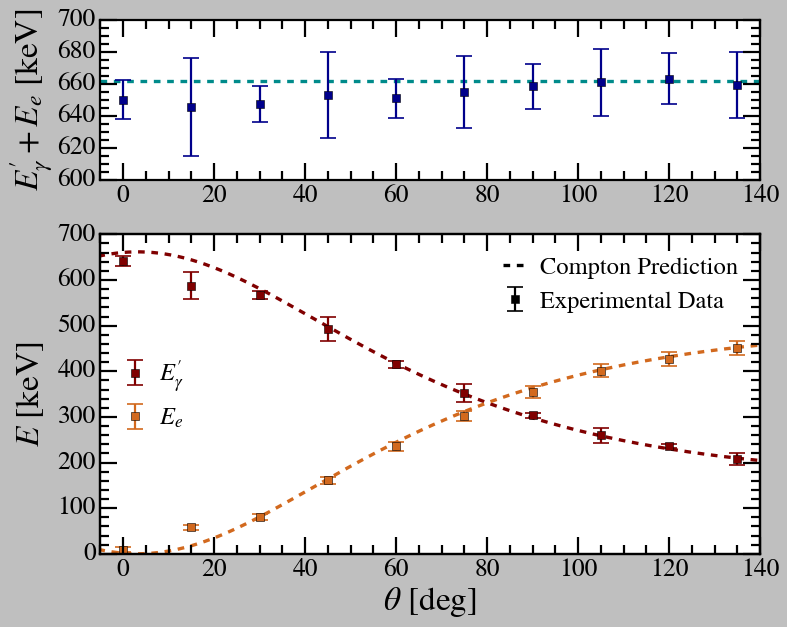

In [22]:
fig, axs = plt.subplots(2,1,figsize=(10,8),height_ratios=[0.5,1])

show_total_energy(compton_measurements,axs[0])
show_scatter_and_recoil_energy(compton_measurements,axs[1])

plt.tight_layout()
plt.savefig('report/Figures/energy_angle_dependency.png')

plt.show()

In [23]:
class ThompsonScatteringFitter(fitting.BaseFitter):
    def __init__(self,thetas,scattering_rates,scattering_rates_err,theta0):
        super().__init__(thetas,scattering_rates,scattering_rates_err)

        self.theta0 = theta0

    def _get_initial_guess(self):
        return [1]
    
    def _get_model(self,x,params):
        I = params[0]
        return I * (1 + np.cos(np.deg2rad(x-self.theta0))**2)

class KleinNishinaScatteringFitter(fitting.BaseFitter):
    p = 661.7
    me = 511

    def __init__(self,thetas,scattering_rates,scattering_rates_err,theta0):
        super().__init__(thetas,scattering_rates,scattering_rates_err)
        
        self.theta0 = theta0

    def _get_initial_guess(self):
        return [1]
    
    def _get_model(self,x,params):
        I = params[0]
        lambda_lambdap = 1 / (1 + self.p/self.me*(1 - np.cos(np.deg2rad(x-self.theta0))))

        return I * lambda_lambdap**2 * (lambda_lambdap + 1/lambda_lambdap - np.sin(np.deg2rad(x-self.theta0))**2)

In [24]:
def show_scattering_rate(compton_measurements,ax):
    # ax.errorbar(compton_measurements.angles, compton_measurements.photon_fwhm_rate, yerr=compton_measurements.photon_fwhm_rate_err,
    #             fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
    #             color='maroon',label=r'$\Gamma_\gamma^\prime$')
    ax.errorbar(compton_measurements.angles, compton_measurements.electron_fwhm_rate, yerr=compton_measurements.electron_fwhm_rate_err,
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='chocolate',label=r'Experimental Data',zorder=-1)
    
    compton_fitter = ComptonScatteringFitter(compton_measurements.angles,compton_measurements.photon_mu_energy,compton_measurements.photon_mu_energy_err)
    theta0 = compton_fitter.fit()['params'][0]

    fitting_idx = np.arange(compton_measurements.angles.size)[1:]
    
    def scatter_rate_fitter(fitter_clase,color,ls,label,zorder):
        fitter = fitter_clase(compton_measurements.angles[fitting_idx],compton_measurements.electron_fwhm_rate[fitting_idx],compton_measurements.electron_fwhm_rate_err[fitting_idx],theta0=theta0)
        result = fitter.fit()
        print(result)
        reduced_chisqr = result["reduced_chisqr"]
        dense_angles, dense_scattering_rates = fitter.model_interpolation(params=result['params'])

        ax.plot(dense_angles, dense_scattering_rates, color=color, ls=ls, label=rf'{label}, $\chi^2_r = {reduced_chisqr:.2f}$', zorder=zorder)

    scatter_rate_fitter(KleinNishinaScatteringFitter,color='darkcyan',ls='-',label='Klein-Nishina Scattering',zorder=-2)
    scatter_rate_fitter(ThompsonScatteringFitter,color='darkslategrey',ls='--',label='Thompson Scattering',zorder=-3)
    
    ax.set_xlim(-5, 140)
    ax.set_ylim(0, 12)

    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$k \, I \, \Omega_{\rm{d}} \, \left({\rm{d}} \sigma / {\rm{d}} \Omega\right)$ [s$^{-1}$]')

    ax.legend(loc='upper right', frameon=False, fontsize=20, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

{'params': array([5.79171867]), 'e_params': array([0.12049797]), 'chisqr': 13.85275007570924, 'reduced_chisqr': 1.731593759463655, 'alpha': 0.0856850897776198, 'cov': array([[0.01451976]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}
{'params': array([2.50121005]), 'e_params': array([0.01606045]), 'chisqr': 132.61688385371096, 'reduced_chisqr': 16.57711048171387, 'alpha': 0.0, 'cov': array([[0.00025794]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


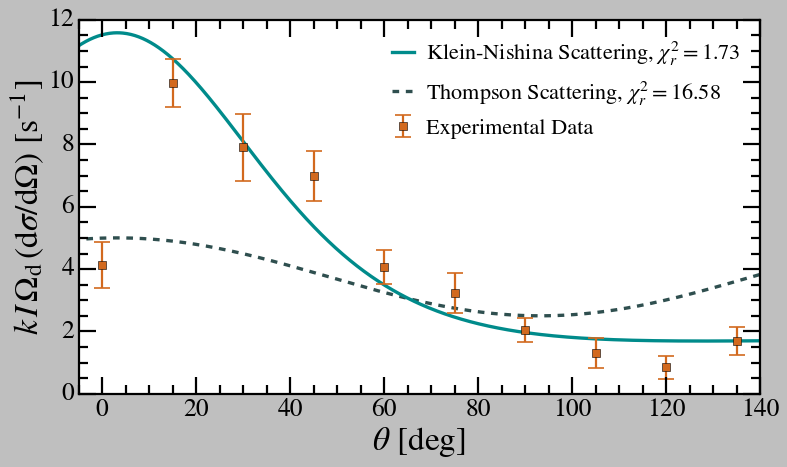

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

show_scattering_rate(compton_measurements,ax)

plt.tight_layout()
plt.savefig('report/Figures/scattering_rate.png')
plt.show()